In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import os

# List files in the specified directory
os.listdir(data_path)


['100141.jpg',
 '100099.jpg',
 '100094.jpg',
 '100163.jpg',
 '100114.jpg',
 '100101.jpg',
 '100106.jpg',
 '10010.jpg',
 '100091.jpg',
 '100242.jpg',
 '100098.jpg',
 '100192.jpg',
 '100105.jpg',
 '100267.jpg',
 '100318.jpg',
 '100075.jpg',
 '100219.jpg',
 '10011.jpg',
 '100100.jpg',
 '100089.jpg',
 '100115.jpg',
 '100097.jpg',
 '100025.jpg',
 '100090.jpg',
 '100048.jpg',
 '100103.jpg',
 '100290.jpg',
 '100095.jpg',
 '100104.jpg',
 '100093.jpg',
 '100113.jpg',
 '100107.jpg',
 '100117.jpg',
 '100137.jpg',
 '100118.jpg',
 '100143.jpg',
 '100136.jpg',
 '100152.jpg',
 '100146.jpg',
 '100154.jpg',
 '100373.jpg',
 '100120.jpg',
 '100346.jpg',
 '100133.jpg',
 '10015.jpg',
 '100150.jpg',
 '100413.jpg',
 '100129.jpg',
 '100131.jpg',
 '100119.jpg',
 '100151.jpg',
 '100127.jpg',
 '100148.jpg',
 '100132.jpg',
 '100134.jpg',
 '100145.jpg',
 '100125.jpg',
 '100153.jpg',
 '100394.jpg',
 '100123.jpg',
 '10013.jpg',
 '100121.jpg',
 '100128.jpg',
 '100130.jpg',
 '100149.jpg',
 '100155.jpg',
 '100142.jpg',

In [ ]:
# Set up the data path
data_path = "/content/drive/MyDrive/dashtoon/train_1/train_1"  # Change this to the path of your dataset

In [ ]:
# Define the neural network architecture for style learning
def build_style_network(input_shape):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))

    return model

In [ ]:
# Instantiate the style network
input_shape = (224, 224, 3)  # Adjust based on your dataset and image dimensions
style_network = build_style_network(input_shape)


In [ ]:
# Compile the style network
style_network.compile(optimizer='adam', loss='mse')

In [ ]:
# Create a data generator for loading images from the dataset
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

In [ ]:
# Get a list of all image files in the directory
file_list = [f for f in os.listdir(data_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

In [ ]:
print(len(file_list))

1079


In [ ]:
# Load and preprocess the data using the generator
train_generator = datagen.flow_from_directory(
    data_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode=None,  # This is a regression problem, so we don't need labels
    shuffle=True
)

Found 0 images belonging to 0 classes.


Error loading 101947.jpg: image file is truncated (80 bytes not processed)


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


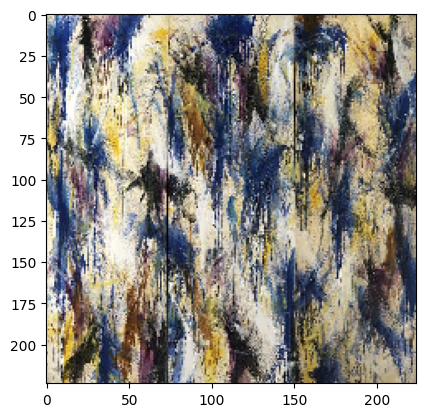

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import os
import numpy as np
import matplotlib.pyplot as plt

# Set the path to the directory containing your images
# data_path = "/content/drive/MyDrive/path/to/your/dataset"

# Create an ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)

# Get a list of all image files in the directory
file_list = [f for f in os.listdir(data_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

# Specify the target size for the images
target_size = (224, 224)

# Initialize an empty list to store the preprocessed images
images = []

# Load and preprocess each image
for filename in file_list:
    try:
        # Construct the full path to the image file
        image_path = os.path.join(data_path, filename)

        # Load the image
        img = load_img(image_path, target_size=target_size)

        # Convert the image to a numpy array and preprocess it
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = datagen.standardize(img_array)

        # Append the preprocessed image to the list
        images.append(img_array)

    except Exception as e:
        print(f"Error loading {filename}: {str(e)}")


# Convert the list of images to a numpy array
images_array = np.vstack(images)

# Display one of the preprocessed images
plt.imshow(images_array[0])
plt.show()


In [ ]:
print(len(images_array))

1078


In [ ]:
# Train the style network
num_epochs = 10  # Adjust as needed

# Create dummy target data for the MSE loss
dummy_targets = np.zeros((len(images_array), 224))  # Assuming the output dimension is 256, adjust if needed

# Wrap the training loop in a function to avoid the tf.function issue
def train_style_network(style_network, input_data, target_data, num_epochs):
    optimizer = tf.optimizers.Adam(learning_rate=0.001)  # You can adjust the learning rate

    for epoch in range(num_epochs):
        # Shuffle the data for each epoch (if needed)
        np.random.shuffle(input_data)

        # Iterate over batches
        for i in range(0, len(input_data), batch_size):
            batch_input = input_data[i:i+batch_size]
            batch_target = target_data[i:i+batch_size]

            # Perform one optimization step
            with tf.GradientTape() as tape:
                loss = style_network.train_on_batch(batch_input, batch_target)

            # Get the gradients
            gradients = tape.gradient(loss, style_network.trainable_variables)

            # Apply the gradients
            optimizer.apply_gradients(zip(gradients, style_network.trainable_variables))

            # Display intermediate results
            print(f"Epoch {epoch + 1}/{num_epochs}, Batch {i // batch_size + 1}, Loss: {loss}")

# Call the training function
train_style_network(style_network, images_array, dummy_targets, num_epochs)


InvalidArgumentError: ignored

In [ ]:
# Train the style network
num_epochs = 10  # Adjust as needed
style_network.fit(images_array, epochs=num_epochs)

Epoch 1/10


ValueError: ignored

In [ ]:
# Wrap the training loop in a function
def train_style_network(style_network, input_data, target_data, num_epochs):
    optimizer = tf.optimizers.Adam(learning_rate=0.001)  # You can adjust the learning rate

    # Compile the model to set optimizer and loss function
    style_network.compile(optimizer=optimizer, loss='mse')  # Assuming 'mse' is the appropriate loss function

    for epoch in range(num_epochs):
        # Shuffle the data for each epoch (if needed)
        indices = np.arange(len(input_data))
        np.random.shuffle(indices)

        for i in range(0, len(indices), batch_size):
            batch_indices = indices[i:i+batch_size]
            batch_input = input_data[batch_indices]
            batch_target = target_data[batch_indices]

            # Train on the batch using train_step
            with tf.GradientTape() as tape:
                loss = style_network.train_on_batch(batch_input, batch_target)

            # Get the gradients
            gradients = tape.gradient(loss, style_network.trainable_variables)

            # Apply the gradients
            optimizer.apply_gradients(zip(gradients, style_network.trainable_variables))

            # Display intermediate results
            print(f"Epoch {epoch + 1}/{num_epochs}, Batch {i // batch_size + 1}, Loss: {loss}")


In [ ]:
# Call the training function
train_style_network(style_network, images_array, dummy_targets, num_epochs)

TypeError: ignored

In [ ]:
# Create a dummy target array
dummy_targets = np.zeros((len(images_array), 256))  # Assuming the output dimension is 256, adjust if needed

# Wrap the training loop in a function
def train_style_network(style_network, input_data, target_data, num_epochs):
    optimizer = tf.optimizers.Adam(learning_rate=0.001)  # You can adjust the learning rate

    # Compile the model to set optimizer and loss function
    style_network.compile(optimizer=optimizer, loss='mse')  # Assuming 'mse' is the appropriate loss function
    # Build the model to ensure it is properly initialized
    style_network.build((None,) + input_data.shape[1:])

    for epoch in range(num_epochs):
        # Shuffle the data for each epoch (if needed)
        indices = np.arange(len(input_data))
        np.random.shuffle(indices)

        for i in range(0, len(indices), batch_size):
            batch_indices = indices[i:i+batch_size]
            batch_input = input_data[batch_indices]
            batch_target = target_data[batch_indices]

            # Train on the batch using train_step
            with tf.GradientTape() as tape:
                loss = style_network.train_on_batch(batch_input, batch_target)

            # Get the gradients
            gradients = tape.gradient(loss, style_network.trainable_variables)

            # Apply the gradients
            optimizer.apply_gradients(zip(gradients, style_network.trainable_variables))

            # Display intermediate results
            print(f"Epoch {epoch + 1}/{num_epochs}, Batch {i // batch_size + 1}, Loss: {loss}")


In [ ]:
# Convert images_array and dummy_targets to float32
images_array = images_array.astype(np.float32)
dummy_targets = dummy_targets.astype(np.float32)

# Wrap the training loop in a function
def train_style_network(style_network, input_data, target_data, num_epochs):
    optimizer = tf.optimizers.Adam(learning_rate=float(0.0000000000001))  # You can adjust the learning rate

    # Compile the model to set optimizer and loss function
    style_network.compile(optimizer=optimizer, loss='mse')  # Assuming 'mse' is the appropriate loss function
    # Build the model to ensure it is properly initialized
    style_network.build((None,) + input_data.shape[1:])

    for epoch in range(num_epochs):
        # Shuffle the data for each epoch (if needed)
        indices = np.arange(len(input_data))
        np.random.shuffle(indices)

        for i in range(0, len(indices), batch_size):
            batch_indices = indices[i:i+batch_size]
            batch_input = input_data[batch_indices]
            batch_target = target_data[batch_indices]

            # Train on the batch using train_step
            with tf.GradientTape() as tape:
                loss = style_network.train_on_batch(batch_input, batch_target)

            # Get the gradients
            gradients = tape.gradient(loss, style_network.trainable_variables)
            gradients = [tf.convert_to_tensor(g) for g in gradients]

            # Apply the gradients
            optimizer.apply_gradients(zip(gradients, style_network.trainable_variables))

            # Display intermediate results
            print(f"Epoch {epoch + 1}/{num_epochs}, Batch {i // batch_size + 1}, Loss: {loss}")

# Call the training function
train_style_network(style_network, images_array, dummy_targets, num_epochs)


TypeError: ignored

In [ ]:
# Call the training function
train_style_network(style_network, images_array, dummy_targets, num_epochs)

TypeError: ignored

In [ ]:
pip install torch torchvision Pillow matplotlib


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 149MB/s]


Iteration: 0, Total Loss: 15.346389770507812
Iteration: 100, Total Loss: 0.47445809841156006
Iteration: 200, Total Loss: 0.21600446105003357
Iteration: 300, Total Loss: 0.1382272094488144
Iteration: 400, Total Loss: 0.10164924710988998


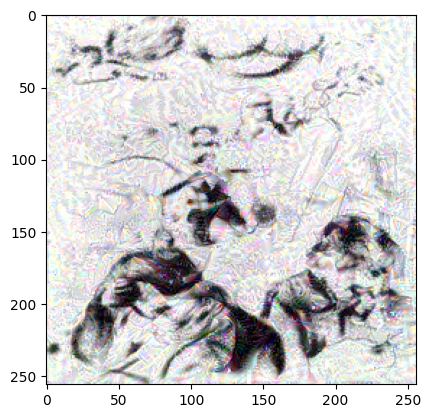

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# Check if GPU is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the neural network architecture for style learning
class StyleNetwork(nn.Module):
    def __init__(self):
        super(StyleNetwork, self).__init__()
        # You can define your architecture here, for simplicity using VGG19
        self.vgg = models.vgg19(pretrained=True).features.eval()
        # Remove the fully connected layers
        self.vgg = nn.Sequential(*list(self.vgg.children())[:-2])

    def forward(self, x):
        return self.vgg(x)

# Function to load and preprocess an image
def load_and_preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])

    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)
    return image

# Function to calculate gram matrix for style loss
def gram_matrix(input_tensor):
    b, c, h, w = input_tensor.size()
    features = input_tensor.view(b, c, h * w)
    gram = torch.bmm(features, features.transpose(1, 2)) / (c * h * w)
    return gram

# Function to calculate style loss
def style_loss(style, gram_target):
    return torch.mean((gram_matrix(style) - gram_target)**2)

# Function to calculate content loss
def content_loss(content, target):
    return torch.mean((content - target)**2)

# Function to perform neural style transfer
def neural_style_transfer(content_image_path, style_image_path, output_image_path, num_iterations=1000):
    content_image = load_and_preprocess_image(content_image_path)
    style_image = load_and_preprocess_image(style_image_path)

    # Create the style network
    style_network = StyleNetwork()

    # Extract features from VGG19 for style image
    with torch.no_grad():
        style_features = style_network(style_image)

    # Set up content image as a parameter for optimization
    content_image.requires_grad_(True)

    # Define the optimizer
    optimizer = optim.Adam([content_image], lr=0.01)

    # Training loop
    for iteration in range(num_iterations):
        optimizer.zero_grad()

        # Forward pass for content and style images
        content_features = style_network(content_image)

        # Calculate content and style losses
        content_loss_value = content_loss(content_features, style_features)
        style_loss_value = style_loss(content_features, gram_matrix(style_features))

        # Total loss
        total_loss = content_loss_value + 1e5 * style_loss_value

        # Backward pass and optimization step
        total_loss.backward()
        optimizer.step()

        # Display intermediate results
        if iteration % 100 == 0:
            print(f"Iteration: {iteration}, Total Loss: {total_loss.item()}")

    # Save the final stylized image
    final_stylized_image = content_image.squeeze(0).permute(1, 2, 0).detach().numpy()
    final_stylized_image = final_stylized_image.clip(0, 1)
    plt.imshow(final_stylized_image)
    plt.savefig(output_image_path)
    plt.show()

# Example usage
neural_style_transfer(
    content_image_path="/content/drive/MyDrive/dashtoon/train_1/train_1/100003.jpg",
    style_image_path="/content/drive/MyDrive/dashtoon/train_1/train_1/100009.jpg",
    output_image_path="/content/drive/MyDrive/dashtoon/train_1/new2.jpg",
    num_iterations=500
)
